# Quran Reciter Identification (Speech Recognition) using Machine Learning
#### by Muhammad Khurram Chughtai

# 3_Training_Testing
This notebook loads the train/val/test data, trains the NN, and tests it on the test data.

Let's start by loading all the helper procedures into the Notebook.
Loading helper procedures from helpers.py:
- Create a new cell & execute the following line
        %load helpers.py
- This will put the contents of the file in the cell. Then execute the cell to load everything in memory

**Note**: Start by cutting the cell below to replace it with empty new cell

In [1]:
# %load helpers.py
##################
# imports
import os
import csv
import re
import pathlib
import xml.etree.ElementTree as ET
import zipfile
import shutil
import librosa
import math
import numpy as np 
import pandas as pd 
import warnings
import audioread
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pydub.utils import mediainfo

##################
# Default Constants
# Directory where MP3 files have been downloaded
zip_data_dir   = '../DownloadedReciters'
# Name of ZIP file for each reciter
zip_file_name  = '000_versebyverse.zip'
# Directory where processed data & other generated data will be stored
data_dir       = '../data'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
quran_meta_xml = os.path.join(os.getcwd(), 'Qurandata', "quran-data.xml")
# Max/Min number of Sura/Aya with first as index 1
SuraIndexMIN   = 1
SuraIndexMAX   = 114
AyaIndexMIN    = 0
AyaIndexMAX    = 6236

# Suppress this warning from librosa:
# UserWarning: PySoundFile failed. Trying audioread instead.
warnings.filterwarnings('ignore')

##################
# Functions
def qsura_ayat_to_labels(suraFrom=None, suraTo=None, ayaFrom=None, ayaTo=None):
    """ Converts either Sura or Aya numbers to labels.

       :param suraFrom: An interger for Sura index to start from. Valid numbers are 1 to 114 (default: None)
       :type suraFrom: int
       :param suraTo: An interger for Sura index to end to. Valid numbers are 1 to 114 (inclusive) (default: None)
       :type suraTo: int
       :param ayaFrom: An interger for Aya index to start from (default: None)
       :type ayaFrom: int
       :param ayaTo: An interger for Aya index to end to (inclusive) (default: None)
       :type ayaTo: int
       :return: A list of labels in the form ['001001', '001002', ...], A list of aya number in quran [0, 2, ... AyaIndexMAX]
       :rtype: list, list 

    """

    # Return lists
    labels_list = list()
    ayainq = list()

    useSura = False
    useAya = False
    if suraFrom is not None and suraTo is not None:
        if suraFrom < SuraIndexMIN or suraFrom > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraFrom', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        if suraTo < SuraIndexMIN or suraTo > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraTo', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        useSura = True
    elif ayaFrom is not None and ayaTo is not None:
        if ayaFrom < AyaIndexMIN or ayaFrom > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaFrom', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        if ayaTo < AyaIndexMIN or ayaTo > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaTo', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        useAya = True

    ##################
    # qmeta: Quran Meta Data
    qmeta_tree = ET.parse(quran_meta_xml)
    qmeta_root = qmeta_tree.getroot()
    #print("qmeta_root :", qmeta_root)

    # As an Element, root has a tag and a dictionary of attributes:
    qmeta_root_tag = qmeta_root.tag
    qmeta_root_att = qmeta_root.attrib
    #print("qmeta_root_tag = " + qmeta_root_tag)
    #print("qmeta_root_att = ")
    #print(qmeta_root_att)

    # It also has children nodes over which we can iterate:
    for qmeta_suras in qmeta_root:
        qmeta_suras_tag = qmeta_suras.tag
        #qmeta_suras_att = qmeta_suras.attrib
        #print("qmeta_suras_tag = " + qmeta_suras_tag)
        #print("qmeta_suras_att = ")
        #print(qmeta_suras_att)
        if qmeta_suras_tag == "suras":
            for qmeta_sura in qmeta_suras:
                qmeta_sura_tag = qmeta_sura.tag
                #qmeta_sura_att = qmeta_sura.attrib
                #print("qmeta_sura_tag = " + qmeta_sura_tag)
                #print("qmeta_sura_att = ")
                #print(qmeta_sura_att)
                if qmeta_sura_tag == "sura":
                    #print("qmeta_sura :", qmeta_sura)
                    qmeta_sura_index = qmeta_sura.attrib.get('index')
                    qmeta_sura_ayas = qmeta_sura.attrib.get('ayas')
                    qmeta_sura_start = qmeta_sura.attrib.get('start')
                    #print("qmeta_sura_index :", qmeta_sura_index)
                    #print("qmeta_sura_ayas :", qmeta_sura_ayas)
                    #print("qmeta_sura_start :", qmeta_sura_start)

                    if useSura:
                        if int(qmeta_sura_index) >= suraFrom and int(qmeta_sura_index) <= suraTo:
                            #print("  MKC: qmeta_sura_index :", qmeta_sura_index)
                            #print("  MKC: qmeta_sura_ayas :", qmeta_sura_ayas)
                            #print("  MKC: qmeta_sura_start :", qmeta_sura_start)
                            for i in range(1, int(qmeta_sura_ayas)+1):
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i))

                    if useAya:
                        # Get the current sura end ayat
                        sura_start = int(qmeta_sura_start)
                        sura_end = sura_start + (int(qmeta_sura_ayas) - 1)
                        #print("sura start -> end: {} -> {}".format(sura_start, sura_end))
                        for i in range(sura_start, sura_end+1):
                            if i >= ayaFrom and i <= ayaTo:
                                #print("  -> ",i)
                                ayainq.append(i)
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i+1-sura_start))

    #print("labels_list :", labels_list)
    return labels_list, ayainq

def report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name):
    """ Reports statitics for the zipped data

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :return: A list of directory names in zip_data_dir
       :rtype: list 

    """

    # Return list
    dir_names = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:8s} {:9s}".format("Reciter name", "Data Size", "Files", "MP3 Files"))
    print("{:30s} {:10s} {:8s} {:9s}".format("============", "=========", "=====", "========="))
    for dd in os.listdir(zip_data_dir):
        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))
        dir_names.append(dd)
    return dir_names

# Directory size (https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python)
def get_dir_size(start_path = '.'):
    """ Gets the size of the directory recursively

       :param start_path: Path to a directory whose size is needed
       :type start_path: str
       :return: Total size of the directory in bytes
       :rtype: int

    """

    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

def report_stats_audio_data(data_dir=audio_data_dir, verbose=False):
    """ Reports statitics for the audio data

       :param data_dir: Directory containing the audio data
       :type data_dir: str
       :return: DataFrame with audio directory details
       :rtype: DataFrame 

    """

    column_names = list()
    column_names.append('ReciterName')
    column_names.append('FileName')
    column_names.append('DataSizeKB')
    column_names.append('BitRate')
    column_names.append('Channels')
    column_names.append('Mono/Stereo')
    column_names.append('Duration')
    column_names.append('FileNoExt')
    column_names.append('Sura')
    column_names.append('Aya')
    column_names.append('AyaInQuran')

    sv_reciter   = list()
    sv_file_name = list()
    sv_data_size = list()
    sv_bit_rate  = list()
    sv_ch        = list()
    sv_ms        = list()
    sv_dur       = list()
    sv_filenoext = list()
    sv_sura      = list()
    sv_aya       = list()
    sv_ayainq    = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("Reciter name/MP3 File", "Data Size", "MP3s", "kbps", "Ch", "Mono/S", "Duration(sec)"))
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("==============================", "=========", "====", "====", "==", "======", "============="))
    for dd in os.listdir(data_dir):
        reciter_dir = os.path.join(data_dir, dd)
        # Size
        #dd_size_bytes = os.path.getsize(reciter_dir)
        dd_size_bytes = get_dir_size(reciter_dir)
        dd_size_KB = dd_size_bytes / (1024)
        # Number of files
        num_files = len(os.listdir(reciter_dir))
        # Mp3 files
        mp3_cnt = 0
        for ff in os.listdir(reciter_dir):
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} KB {:5d}".format(dd, dd_size_KB, mp3_cnt))

        for ff in os.listdir(reciter_dir):
            if not ff.endswith('.mp3'):
                continue
            mp3_file = os.path.join(reciter_dir, ff)

            duration = channel_layout = bit_rate = channels = bit_rate_kbps = -1
            try:
                # Look at some audio features
                y, sr = librosa.load(mp3_file, sr=None)
                # Get the length of the audio
                duration = librosa.core.get_duration(y=y, sr=sr)
                duration = len(y) / sr

                # Sample rate
                info = mediainfo(mp3_file)
                #print(info)
                channel_layout = info['channel_layout']
                bit_rate = int(info['bit_rate'])
                channels = int(info['channels'])
                #artist = info['artist']
                artist = ""
                bit_rate_kbps = bit_rate / 1000
            
            except:
                print("Couldn't process, skipping: ", mp3_file)

            #print("{:>30s} {:6.0f} KB {:5d} {:12d} {:5.1f}".format(ff, dd_size_KB, 0, int(info['sample_rate']), duration))
            #with audioread.audio_open(mp3_file) as input_file:
            #    sr_native = input_file.samplerate
            #    n_channels = input_file.channels
            #print(sr_native, n_channels)
            if verbose == True:
                print("{:>30s} {:6.0f} KB {:5s} {:4.0f} {:2d} {:6s} {:13.1f}".format(ff, dd_size_KB, "", bit_rate_kbps, channels, channel_layout, duration))

            # Size
            dd_size_bytes = os.path.getsize(mp3_file)
            dd_size_KB = dd_size_bytes / (1024)

            sv_reciter.append(dd)
            sv_file_name.append(ff)
            sv_data_size.append(int(dd_size_KB))
            sv_bit_rate.append(int(bit_rate_kbps))
            sv_ch.append(channels)
            sv_ms.append(channel_layout)
            sv_dur.append(duration)
            filenoext, sura, aya, ayainq = get_mp3_file_info(ff)
            sv_filenoext.append(filenoext)
            sv_sura.append(sura)
            sv_aya.append(aya)
            sv_ayainq.append(ayainq)
            #break
        #break
    
    # Create a DataFrame with all the info
    df = pd.DataFrame(list(zip(sv_reciter, sv_file_name, sv_data_size, 
        sv_bit_rate, sv_ch, sv_ms, sv_dur, sv_filenoext, sv_sura, sv_aya, sv_ayainq)), 
               columns=column_names) 

    return df

def get_mp3_file_info(file_name):
    """ Get info from MP3 file name. Use lbl_aya_dict dictionary for lookup so this variable needs to be defined before.

       :param file_name: MP3 file name
       :type file_name: str
       :return: label, sura, aya, ayainquran
       :rtype: str 

    File name should be ######.mp3, e.g. 001004.mp3
        SuraAya    = 001004
        Sura       = 1
        Aya        = 4
        AyaInQuran = 3
    """

    # Return items
    suraaya   = ''
    sura      = -1
    aya       = -1
    ayainquan = -1

    suraaya = os.path.splitext(file_name)[0]
    sura = int(suraaya[:3])
    aya  = int(suraaya[3:])
    ayainquan = int(lbl_aya_dict[suraaya])

    return suraaya, sura, aya, ayainquan

def audio_data_initialize(dir_name=audio_data_dir):
    """ Initialize audio data directory

       :param dir_name: Directory name to initialize
       :type dir_name: str
       :return: dir_name
       :rtype: str 

    """

    # If directory exists, delete the directory 
    if pathlib.Path(dir_name).exists():
        print("Directory exists, deleting :", dir_name)
        #pathlib.Path(dir_name).rmdir()
        shutil.rmtree(dir_name)

    # Create the directory
    print("Creating directory :", dir_name)
    pathlib.Path(dir_name).mkdir()

    return dir_name

def populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=None, suraFrom=None, suraTo=None,
        ayaFrom=None, ayaTo=None):
    """ Populate audio files for the reciters in the given directory.

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :param audio_data_dir: Name of the download directory with the reciter zip files
       :type audio_data_dir: str
       :param reciters: Name(s) of the reciters. Only their data will be processed, rest will be ignored
       :type reciters: list of strings
       :param suraFrom: Starting sura
       :type suraFrom: int
       :param suraTo: Ending sura
       :type suraTo: int
       :param ayaFrom: Starting aya
       :type ayaFrom: int
       :param ayaTo: Ending aya
       :type ayaTo: int
       :return: None
       :rtype: None

    """

    # Convert SuraAya.mp3 name to AyaInQuran 
    audio_labels, ayainq_list = qsura_ayat_to_labels(suraFrom=suraFrom, suraTo=suraTo, 
        ayaFrom=ayaFrom, ayaTo=ayaTo)
    #print("Audio labels: ", audio_labels)
    #print("Aya in Quran labels: ", ayainq_list)

    for dd in os.listdir(zip_data_dir):
        if dd not in reciters:
            continue

        print("Found reciter: ", dd)
        # Create the directory
        reciter_dir = os.path.join(audio_data_dir, dd)
        print("Creating directory :", reciter_dir)
        pathlib.Path(reciter_dir).mkdir()

        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))

        num_files_extracted = 0
        for lbl in audio_labels:
            mp3_file = lbl + ".mp3"
            if mp3_file not in archive.namelist():
                print("ERROR: Couldn't find file: ", mp3_file)
                continue
            archive.extract(mp3_file, path=reciter_dir)
            num_files_extracted += 1
        print("{} files extracted".format(num_files_extracted))
    print()

    return None


def extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512,
    pad_duration=None, read_duration=None, features_list=['mfcc', 'zcr', 'spectral_center', 
    'spectral_rolloff', 'chroma', 'spectral_bandwidth_2', 'spectral_bandwidth_3', 
    'spectral_bandwidth_4', 'spectral_contrast'], shp_0=None, shp_1=None, normalization=True):
    """ Extract the requested audio features.

       :param reciter: Name of the reciter
       :type reciter: str
       :param mp3_file: Name of the mp3_file
       :type mp3_file: str
       :param sr: Sampling rate to apply during audio file read with librosa
       :type sr: int
       :param n_mfcc: Number of MFCC features to return by librosa
       :type n_mfcc: int
       :param n_fft: Number of Fast Frourier Transform frequeny bins to use with librosa
       :type n_fft: int
       :param hop_length: hop_length for librosa. This says how much to overlap audio frame windows during feature extraction.
       :type hop_length: int
       :param pad_duration: Pad the duration to this number if the duration of the MP3 file is shorter
       :type pad_duration: int
       :param read_duration: Read only this much duration from the audio file
       :type read_duration: int
       :param features_list: List of features to extract
       :type features_list: list
       :param shp_0: Initialize the return data NumPy array with this shape
       :type shp_0: int
       :param shp_1: Initialize the return data NumPy array with this shape
       :type shp_1: int
       :param normalization: Normalize the MFCC data. Only works for the MFCC feature
       :type normalization: bool
       :return: columns, data, feature_shapes, new_shp_0, new_shp_1
       :rtype: list, NumPy array, list, int, int

    """

    # File name is dir/reciter/mp3_file
    file_name = os.path.join(audio_data_dir, reciter, mp3_file)

    # Initilize return variables
    columns = data = feature_shapes = new_shp_0 = new_shp_1 = None

    # Few MP3 files for few reciters were corrupted. Give a message about them & bail out
    try:
        y , sr = librosa.load(file_name, sr=sr, duration=read_duration)
        orig_duration = len(y) / sr
        #print("pad_duration = ", pad_duration)
        #print("read_duration = ", read_duration)
        #print("orig_duration = ", orig_duration)
        # Pad the duration
        if pad_duration is not None:
            if pad_duration > orig_duration:
                new_len_y = pad_duration * sr
                y = librosa.util.fix_length(y, new_len_y)
            elif pad_duration <= orig_duration:
                # Nothing to be done!
                pass
        duration = len(y) / sr
        #print("FINAL: duration = ", duration)

        # Column names
        columns = list()

        # Feature shapes
        feature_shapes = list()

        #print("shp_0 :", shp_0)
        #print("shp_1 :", shp_1)
        if shp_0 is not None and shp_1 is not None:
            if 'spect' in features_list:
                #data = np.empty(
                #    (shp_0, shp_1), dtype=np.float64
                #)
                data = np.empty(
                    (shp_1, shp_0), dtype=np.float64
                )
            else:
                data = np.zeros(
                    (shp_1, shp_0), dtype=np.float64
                )
            #data = np.empty(
            #  (0, shp_0, shp_1)
            #)
            #print("data initialized:")
            #print(type(data))
            #print(data.shape)
        else:
            data = list()
            #print(type(data))

        # Start index is 0 and gets updated after feature is concatenated to "data"
        start_idx = 0
        if 'mfcc' in features_list:
            #spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft
            )
            feature_shapes.append(mfcc.shape)
            #print("mfcc:")
            #print(mfcc.shape)
            #print("mfcc.T:")
            #print(mfcc.T)
            #print("mfcc:")
            #print(mfcc)
            #print(np.amin(mfcc), np.amax(mfcc), np.mean(mfcc))
            # Normalize?
            if normalization == True:
                divby = abs(np.amin(mfcc))
                if abs(np.amax(mfcc)) > divby:
                    divby = abs(np.amax(mfcc))

                #print("divby = ", divby)
                mfcc_orig = mfcc
                x = mfcc / divby
                #print("x = ", x)
                #x = mfcc / math.abs()
                mfcc = x
            for i in range(1, mfcc.shape[0]+1):
                columns.append('mfcc{}'.format(i))
            if shp_0 is not None:
                #data = np.append(data, [mfcc.T], axis=0)
                data[:, start_idx:start_idx+mfcc.shape[0]] = mfcc.T[0:mfcc.shape[1], :]
                start_idx += mfcc.shape[0]
                #print("mfcc start_idx updated to: ", start_idx)
        if 'zcr' in features_list:
            zcr = librosa.feature.zero_crossing_rate(y)
            feature_shapes.append(zcr.shape)
            #print("zcr:")
            #print(zcr.shape)
            #print(zcr.T)
            #print(zcr.shape[1])
            columns.append('zcr')
            if shp_0 is not None:
                data[:, start_idx:start_idx+zcr.shape[0]] = zcr.T[0:zcr.shape[1], :]
                start_idx += zcr.shape[0]
                #print("zcr start_idx updated to: ", start_idx)
        if 'spectral_center' in features_list:
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_center.shape)
            #print("spectral_center:")
            #print(spectral_center.shape)
            columns.append('spectral_center')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_center.shape[0]] = spectral_center.T[0:spectral_center.shape[1], :]
                start_idx += spectral_center.shape[0]
                #print("spectral_center start_idx updated to: ", start_idx)
        if 'spectral_rolloff' in features_list:
            #spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)
            feature_shapes.append(spectral_rolloff.shape)
            #print("spectral_rolloff:")
            #print(spectral_rolloff.shape)
            #print(spectral_rolloff)
            columns.append('spectral_rolloff')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_rolloff.shape[0]] = spectral_rolloff.T[0:spectral_rolloff.shape[1], :]
                start_idx += spectral_rolloff.shape[0]
                #print("spectral_rolloff start_idx updated to: ", start_idx)
        if 'chroma' in features_list:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
            feature_shapes.append(chroma.shape)
            #print("chroma:")
            #print(chroma.shape)
            for i in range(1, chroma.shape[0]+1):
                columns.append('chroma{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+chroma.shape[0]] = chroma.T[0:chroma.shape[1], :]
                start_idx += chroma.shape[0]
                #print("chroma start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_2' in features_list:
            spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)
            feature_shapes.append(spectral_bandwidth_2.shape)
            #print("spectral_bandwidth_2:")
            #print(spectral_bandwidth_2.shape)
            columns.append('spectral_bandwidth_2')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_2.shape[0]] = spectral_bandwidth_2.T[0:spectral_bandwidth_2.shape[1], :]
                start_idx += spectral_bandwidth_2.shape[0]
                #print("spectral_bandwidth_2 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_3' in features_list:
            spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)
            feature_shapes.append(spectral_bandwidth_3.shape)
            #print("spectral_bandwidth_3:")
            #print(spectral_bandwidth_3.shape)
            columns.append('spectral_bandwidth_3')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_3.shape[0]] = spectral_bandwidth_3.T[0:spectral_bandwidth_3.shape[1], :]
                start_idx += spectral_bandwidth_3.shape[0]
                #print("spectral_bandwidth_3 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_4' in features_list:
            spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)
            feature_shapes.append(spectral_bandwidth_4.shape)
            #print("spectral_bandwidth_4:")
            #print(spectral_bandwidth_4.shape)
            columns.append('spectral_bandwidth_4')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_4.shape[0]] = spectral_bandwidth_4.T[0:spectral_bandwidth_4.shape[1], :]
                start_idx += spectral_bandwidth_4.shape[0]
                #print("spectral_bandwidth_4 start_idx updated to: ", start_idx)
        if 'spectral_contrast' in features_list:
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_contrast.shape)
            #print("spectral_contrast:")
            #print(spectral_contrast.shape)
            #print(spectral_contrast)
            #print(spectral_contrast.T)
            for i in range(1, spectral_contrast.shape[0]+1):
                columns.append('spcontr{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_contrast.shape[0]] = spectral_contrast.T[0:spectral_contrast.shape[1], :]
                start_idx += spectral_contrast.shape[0]
                #print("spectral_contrast start_idx updated to: ", start_idx)
        if 'spect' in features_list:
            spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            spect = librosa.power_to_db(spect, ref=np.max)
            feature_shapes.append(spect.shape)
            #print("spect:")
            #print(spect.shape)
            for i in range(1, spect.shape[0]+1):
                columns.append('spect{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spect.shape[0]] = spect.T[0:spect.shape[1], :]
                start_idx += spect.shape[0]
                #print("spect start_idx updated to: ", start_idx)

        new_shp_0 = shp_0
        new_shp_1 = shp_1
        if shp_0 is None:
            #print(feature_shapes)
            new_shp_0 = 0
            for i, shp in enumerate(feature_shapes):
                if i == 0:
                    prev_shp_1 = shp[1]
                else:
                    if shp[1] != prev_shp_1:
                        print("ERROR: shape[1] are different: {} != {}".format(shp[1], prev_shp_1))
                print("shp[0] :", shp[0])
                new_shp_0 += shp[0]
            new_shp_1 = prev_shp_1
            print("new_shp_0 :", new_shp_0)
            print("new_shp_1 :", new_shp_1)

        #print("duration :", duration)

    except:
            print("Couldn't process, skipping: ", file_name)

    return columns, data, feature_shapes, new_shp_0, new_shp_1

# Suras: Update 'Set' column with test/train/val in df
def assign_set_sura(row):
    """ Mark Suras for Test/Train/Validation (uses row.Sura column). Requires Train_/Val_/Test_Suras lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Suras
    val   = Val_Suras
    test  = Test_Suras
    if row.Sura in val:
        return "validation"
    elif row.Sura in test:
        return "test"
    else:
        return "train"

# Ayas: Update 'Set' column with test/train/val in df
def assign_set_aya(row):
    """ Mark Ayas for Test/Train/Validation (uses row.AyaInQuran column). Requires Train_/Val_/Test_Ayas lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.AyaInQuran in val:
        return "validation"
    elif row.AyaInQuran in test:
        return "test"
    else:
        return "train"

# Ayas: Update 'Set' column with test/train/val in df
def assign_set_filename(row):
    """ Mark Ayas for Test/Train/Validation (uses row.FileName column). Requires Train_/Val_/Test_Ayas lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.FileName in val:
        return "validation"
    elif row.FileName in test:
        return "test"
    else:
        return "train"

def gen_audio_data(df, shp0, shp1, normalization=True):
    """ Extract audio features for the given df which is a Train/Val/Test subset of the main df.

       :param df: DataFrame
       :type df: DataFrame
       :param shp_0: Initialize the return data NumPy array with this shape
       :type shp_0: int
       :param shp_1: Initialize the return data NumPy array with this shape
       :type shp_1: int
       :param normalization: Normalize the MFCC data. Only works for the MFCC feature
       :type normalization: bool
       :return: X_arr, reciters_arr
       :rtype: NumPy arr, NumPy arr

    """

    print("shp0 shp1 = ", shp0, shp1)
    X_arr = np.empty((0, shp1, shp0))
    print("X_arr initialized to :", X_arr.shape)
    reciters_arr = np.empty((0, len(list(le.classes_))))
    print("reciters_arr initialized to :", reciters_arr.shape)
    print("normalization :", normalization)

    cnt = 0
    for index, row in df.iterrows():
        cnt += 1
        ReciterName = row['ReciterName']
        FileName = row['FileName']
        # Get audio features
        columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
                reciter=ReciterName, mp3_file=FileName, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
                hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
                features_list=features_list, shp_0=shp0, shp_1=shp1, normalization=normalization)
        if columns == None and data == None and feature_shapes == None:
            # Skips in case of errors
            continue

        X_arr = np.append(X_arr, [data], axis=0)
                            
        reciters_list = [0 for i in range(0, len(list(le.classes_)))]
        reciters_index = list(le.transform([ReciterName]))[0]
        reciters_list[reciters_index] = 1
        reciters_arr = np.append(reciters_arr, [reciters_list], axis=0)
            
        if cnt % 100 == 0:
            print("Processed ", cnt)
        #if cnt == 10:
        #    break

    return X_arr, reciters_arr

def filter_duration(row):
    """ Finds the same FileName for all the selected_reciters (uses row.FileName/row.ReciterName columns). Uses selected_reciters variable to look for the recieter, so it needs to be defined.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: 'Yes' or 'NaN'
       :rtype: str

    """

    my_df = df_tmp
    FileName = row.FileName
    #print("FileName =", FileName)
    not_found = False
    for rec in selected_reciters:
        #print("  rec =", rec)
        if ((my_df['ReciterName'] == rec) & (my_df['FileName'] == FileName)).any():
            pass
        else:
            not_found = True
            #print("not_found =", not_found)
            break
    
    if not_found == True:
        return 'NaN'
    else:
        return 'Yes'

print("helpers.py LOADED!")
# End of helpers.py

helpers.py LOADED!


In [2]:
import os

data_dir       = '../data'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
savez_dir = '../datamelspect'

print("      data_dir = ", data_dir)
print("audio_data_dir = ", audio_data_dir)
print("     savez_dir = ", savez_dir)


      data_dir =  ../data
audio_data_dir =  D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio
     savez_dir =  ../datamelspect


In [3]:
import numpy as np
import os
from os.path import isfile
import pathlib
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop, Adadelta
from keras.layers import Bidirectional

from keras import regularizers
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load training and Validation arrays

In [4]:
dict_reciter_to_label =  {'AbdurrahmaanAs-Sudais': 0, 'Ajami': 1, 'Alafasy': 2, 'FaresAbbad': 3, 'Ghamadi': 4}

dict_reciters = dict_reciter_to_label

dict_label_to_reciter = {v: k for k, v in dict_reciters.items()}
print("dict_label_to_reciter = ",dict_label_to_reciter)

dict_label_to_reciter =  {0: 'AbdurrahmaanAs-Sudais', 1: 'Ajami', 2: 'Alafasy', 3: 'FaresAbbad', 4: 'Ghamadi'}


In [5]:
npzfile = np.load(os.path.join(savez_dir, 'shuffled_train_log.npz'))
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(9000, 130, 128) (9000, 5)


In [6]:
npzfile = np.load(os.path.join(savez_dir, 'shuffled_valid_log.npz'))
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(3000, 130, 128) (3000, 5)


### Check by plotting a Spectogram

FaresAbbad


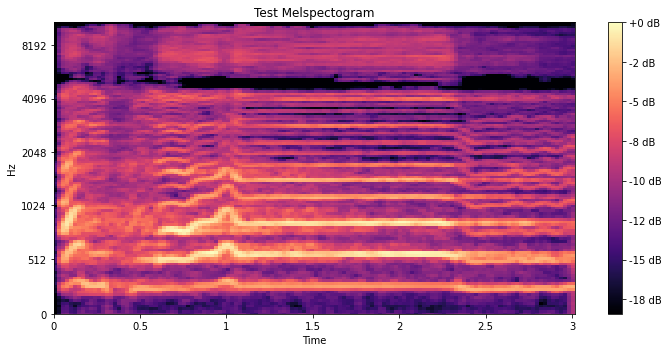

In [7]:
i = 4
spect = X_train[i]
lbl = np.argmax(y_train[i])
print(dict_label_to_reciter[lbl])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spect.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### BiLSTM Model

In [8]:
num_classes = len(dict_reciters)
n_features = X_train.shape[1]
n_time = X_train.shape[2]
print("num_classes =", num_classes)
print("n_features =", n_features)
print("n_time =", n_time)

num_classes = 5
n_features = 130
n_time = 128


In [9]:
# BiLSTM model
BATCH_SIZE = 128
EPOCH_COUNT = 200
print("BATCH_SIZE = ", BATCH_SIZE)
print("EPOCH_COUNT = ", EPOCH_COUNT)

def create_model(model_input):
    n_frequency = n_time
    n_frames = n_features 
    input_shape = (n_frames, n_frequency)

    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh'), input_shape=input_shape))
    model.add(Bidirectional(LSTM(32, return_sequences=True, activation='tanh')))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(rate=0.05))
    model.add(Dense(num_classes, activation='softmax'))

    opt = Adadelta(lr=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    
    print(model.summary())
    return model

BATCH_SIZE =  128
EPOCH_COUNT =  200


In [10]:
import pathlib

my_models_dir = os.path.join(os.getcwd(), "models")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)

my_models_dir = os.path.join(os.getcwd(), "models/bilstm")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)
    
def train_model(x_train, y_train, x_val, y_val, notrain=False):
   
    n_frequency = n_time
    n_frames = n_features 
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = create_model(model_input)
    
    checkpoint_callback = ModelCheckpoint('./models/bilstm/weights.best.{epoch:02d}-{val_accuracy:.2f}.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')

    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    if notrain is True:
        print("No training this time!")
        return None, None
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [11]:
print("Compiling ...")
junk1, junk2  = train_model(X_train, y_train, X_valid, y_valid, notrain=True)

Compiling ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 130, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 130, 64)           41216     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 152,613
Trainable params: 152,613
Non-trainable params: 0
_________________________________________________________________
None
No training this time!


In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
t0 = time.time()

model, history  = train_model(X_train, y_train, X_valid, y_valid)

print("DONE in {:0.3} sec\n".format(time.time() - t0))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 130, 128)          98816     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 130, 64)           41216     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 152,613
Trainable params: 152,613
Non-trainable params: 0
_________________________________________________________________
None
Training...
Train on 9000 samples, validate on 3000 samples
Epoch 1/200
9000/9000 [==========================

9000/9000 [==============================] - 106s 12ms/step - loss: 1.2497 - accuracy: 0.7948 - val_loss: 1.2325 - val_accuracy: 0.8217

Epoch 00028: val_accuracy improved from 0.81167 to 0.82167, saving model to ./models/bilstm/weights.best.28-0.82.h5
Epoch 29/200
9000/9000 [==============================] - 105s 12ms/step - loss: 1.2367 - accuracy: 0.8029 - val_loss: 1.2198 - val_accuracy: 0.8240

Epoch 00029: val_accuracy improved from 0.82167 to 0.82400, saving model to ./models/bilstm/weights.best.29-0.82.h5
Epoch 30/200
9000/9000 [==============================] - 106s 12ms/step - loss: 1.2248 - accuracy: 0.8072 - val_loss: 1.2067 - val_accuracy: 0.8267

Epoch 00030: val_accuracy improved from 0.82400 to 0.82667, saving model to ./models/bilstm/weights.best.30-0.83.h5
Epoch 31/200
9000/9000 [==============================] - 106s 12ms/step - loss: 1.2120 - accuracy: 0.8108 - val_loss: 1.1936 - val_accuracy: 0.8310

Epoch 00031: val_accuracy improved from 0.82667 to 0.83100, savin

9000/9000 [==============================] - 106s 12ms/step - loss: 0.8623 - accuracy: 0.8977 - val_loss: 0.8432 - val_accuracy: 0.8973

Epoch 00059: val_accuracy improved from 0.89567 to 0.89733, saving model to ./models/bilstm/weights.best.59-0.90.h5
Epoch 60/200
9000/9000 [==============================] - 107s 12ms/step - loss: 0.8541 - accuracy: 0.9019 - val_loss: 0.8325 - val_accuracy: 0.8977

Epoch 00060: val_accuracy improved from 0.89733 to 0.89767, saving model to ./models/bilstm/weights.best.60-0.90.h5
Epoch 61/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.8420 - accuracy: 0.9002 - val_loss: 0.8218 - val_accuracy: 0.8993

Epoch 00061: val_accuracy improved from 0.89767 to 0.89933, saving model to ./models/bilstm/weights.best.61-0.90.h5
Epoch 62/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.8295 - accuracy: 0.9023 - val_loss: 0.8111 - val_accuracy: 0.8987

Epoch 00062: val_accuracy did not improve from 0.89933
Epoch 63/2

9000/9000 [==============================] - 105s 12ms/step - loss: 0.7056 - accuracy: 0.9188 - val_loss: 0.6968 - val_accuracy: 0.9073

Epoch 00093: val_accuracy did not improve from 0.90833
Epoch 94/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.7052 - accuracy: 0.9184 - val_loss: 0.6957 - val_accuracy: 0.9073

Epoch 00094: val_accuracy did not improve from 0.90833
Epoch 95/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.7025 - accuracy: 0.9203 - val_loss: 0.6947 - val_accuracy: 0.9073

Epoch 00095: val_accuracy did not improve from 0.90833
Epoch 96/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.7027 - accuracy: 0.9212 - val_loss: 0.6936 - val_accuracy: 0.9073

Epoch 00096: val_accuracy did not improve from 0.90833

Epoch 00096: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 97/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.7017 - accuracy: 0.9196 - val_


Epoch 00130: val_accuracy improved from 0.90900 to 0.90933, saving model to ./models/bilstm/weights.best.130-0.91.h5
Epoch 131/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.6916 - accuracy: 0.9218 - val_loss: 0.6842 - val_accuracy: 0.9093

Epoch 00131: val_accuracy did not improve from 0.90933
Epoch 132/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6923 - accuracy: 0.9203 - val_loss: 0.6842 - val_accuracy: 0.9093

Epoch 00132: val_accuracy did not improve from 0.90933
Epoch 133/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6915 - accuracy: 0.9207 - val_loss: 0.6841 - val_accuracy: 0.9093

Epoch 00133: val_accuracy did not improve from 0.90933
Epoch 134/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6914 - accuracy: 0.9232 - val_loss: 0.6840 - val_accuracy: 0.9093

Epoch 00134: val_accuracy did not improve from 0.90933
Epoch 135/200
9000/9000 [==============================] -


Epoch 00168: val_accuracy did not improve from 0.90933
Epoch 169/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6910 - accuracy: 0.9206 - val_loss: 0.6835 - val_accuracy: 0.9093

Epoch 00169: val_accuracy did not improve from 0.90933
Epoch 170/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6900 - accuracy: 0.9226 - val_loss: 0.6835 - val_accuracy: 0.9093

Epoch 00170: val_accuracy did not improve from 0.90933
Epoch 171/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.6903 - accuracy: 0.9204 - val_loss: 0.6835 - val_accuracy: 0.9093

Epoch 00171: val_accuracy did not improve from 0.90933
Epoch 172/200
9000/9000 [==============================] - 106s 12ms/step - loss: 0.6899 - accuracy: 0.9221 - val_loss: 0.6835 - val_accuracy: 0.9093

Epoch 00172: val_accuracy did not improve from 0.90933
Epoch 173/200
9000/9000 [==============================] - 105s 12ms/step - loss: 0.6914 - accuracy: 0.9196 - val_loss: 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


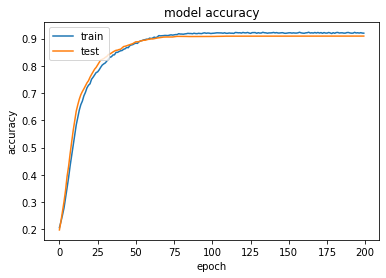

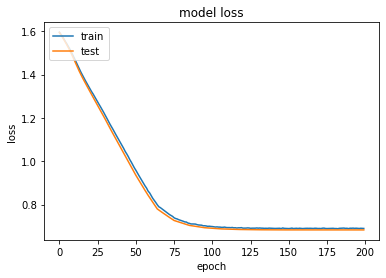

In [14]:
show_summary_stats(history)

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(3000,) (3000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       0.97      0.89      0.93       600
                Ajami       0.93      0.99      0.96       600
              Alafasy       0.77      0.90      0.83       600
           FaresAbbad       0.92      0.79      0.85       600
              Ghamadi       0.98      0.98      0.98       600

             accuracy                           0.91      3000
            macro avg       0.92      0.91      0.91      3000
         weighted avg       0.92      0.91      0.91      3000



In [16]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.9093333333333333


### Connect to Test Set

In [17]:
from keras.models import load_model

#weights_path = 'models/bilstm/weights.best.h5'
#weights_path = './models/bilstm/weights.best.06-0.89.h5'
weights_path = './models/bilstm/weights.best.130-0.91.h5'
model = load_model(weights_path)

In [18]:
npzfile = np.load(os.path.join(savez_dir, 'test_arr.npz'))
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(3000, 130, 128) (3000, 5)


In [19]:
# Convert y_test from shape (?, 5) to (?,)
new_y_test = np.empty(y_test.shape[0])
print(new_y_test.shape)
for i, lst in enumerate(y_test):
    lbl = np.argmax(lst, axis=None, out=None)
    new_y_test[i] = lbl
    if i == -1 or lbl < 0:
        print("i {}, lbl {}, lst {}".format(i,lbl,lst))
        break

print(new_y_test.shape)
y_test = new_y_test

(3000,)
(3000,)


In [20]:
#y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0.0 4.0 2.0


In [21]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.005049899452005801


In [22]:
X_test = np.log(X_test_raw)

from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()
print("labels =", labels)
print("target_names =", target_names)

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

labels = [0, 1, 2, 3, 4]
target_names = dict_keys(['AbdurrahmaanAs-Sudais', 'Ajami', 'Alafasy', 'FaresAbbad', 'Ghamadi'])
(3000,) (3000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       0.93      0.98      0.96       600
                Ajami       0.88      0.94      0.91       600
              Alafasy       0.74      0.82      0.78       600
           FaresAbbad       0.93      0.71      0.81       600
              Ghamadi       0.96      0.97      0.96       600

             accuracy                           0.88      3000
            macro avg       0.89      0.88      0.88      3000
         weighted avg       0.89      0.88      0.88      3000



In [23]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[587   9   0   4   0]
 [ 12 562  12   9   5]
 [ 13  58 491  17  21]
 [ 15   3 155 426   1]
 [  1   9   7   0 583]]


In [24]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.883


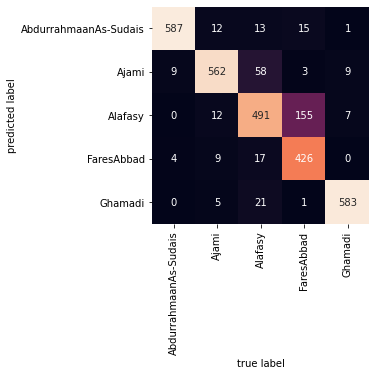

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_reciters.keys(),
            yticklabels=dict_reciters.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
